In [1]:
import tropycal.tracks as tracks
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# Load the HURDAT2 dataset for the North Atlantic basin
basin = tracks.TrackDataset(basin='north_atlantic', source='hurdat', include_btk=False)


--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (2.05 seconds)


In [3]:
#%%
# Initialize lists to store intensity changes for two periods
intensity_changes_1980_2000 = []
intensity_changes_2001_2021 = []

# Loop over each year from 1980 to 2021
for year in range(1980, 2022):
    season = basin.get_season(year)
    season_df = season.to_dataframe()
    storm_names = season_df['name'].tolist()

    for storm_name in storm_names:
        try:
            storm = basin.get_storm((storm_name, year))
        except RuntimeError:
            continue
        
        time = storm['time']
        vmax = storm['vmax']
        lat = storm['lat']
        lon = storm['lon']
        data = {'time': time, 'vmax': vmax, 'lat': lat, 'lon': lon}
        df = pd.DataFrame(data)

        # Extract the hour from the timestamp
        df['hour'] = df['time'].apply(lambda x: x.hour)

        # Filter the DataFrame to only keep rows where the hour is in [0, 6, 12, 18, 24]
        df = df[df['hour'].isin([0, 6, 12, 18, 24])]
        # Drop the 'hour' column as it's no longer needed
        df = df.drop(columns=['hour'])

        # Ensure there are at least 5 valid time steps to check for RI
        if len(df) < 5:
            continue

        # Nested loop to find RI events
        for i in range(len(df) - 4):
            window24hr = [df['vmax'].iloc[i+1] - df['vmax'].iloc[i], 
                          df['vmax'].iloc[i+2] - df['vmax'].iloc[i], 
                          df['vmax'].iloc[i+3] - df['vmax'].iloc[i], 
                          df['vmax'].iloc[i+4] - df['vmax'].iloc[i]]
            idx = np.argmax(window24hr)
            max_24 = window24hr[idx]
            if 1980 <= year <= 2000:
                intensity_changes_1980_2000.append(max_24)
            elif 2001 <= year <= 2021:
                intensity_changes_2001_2021.append(max_24)


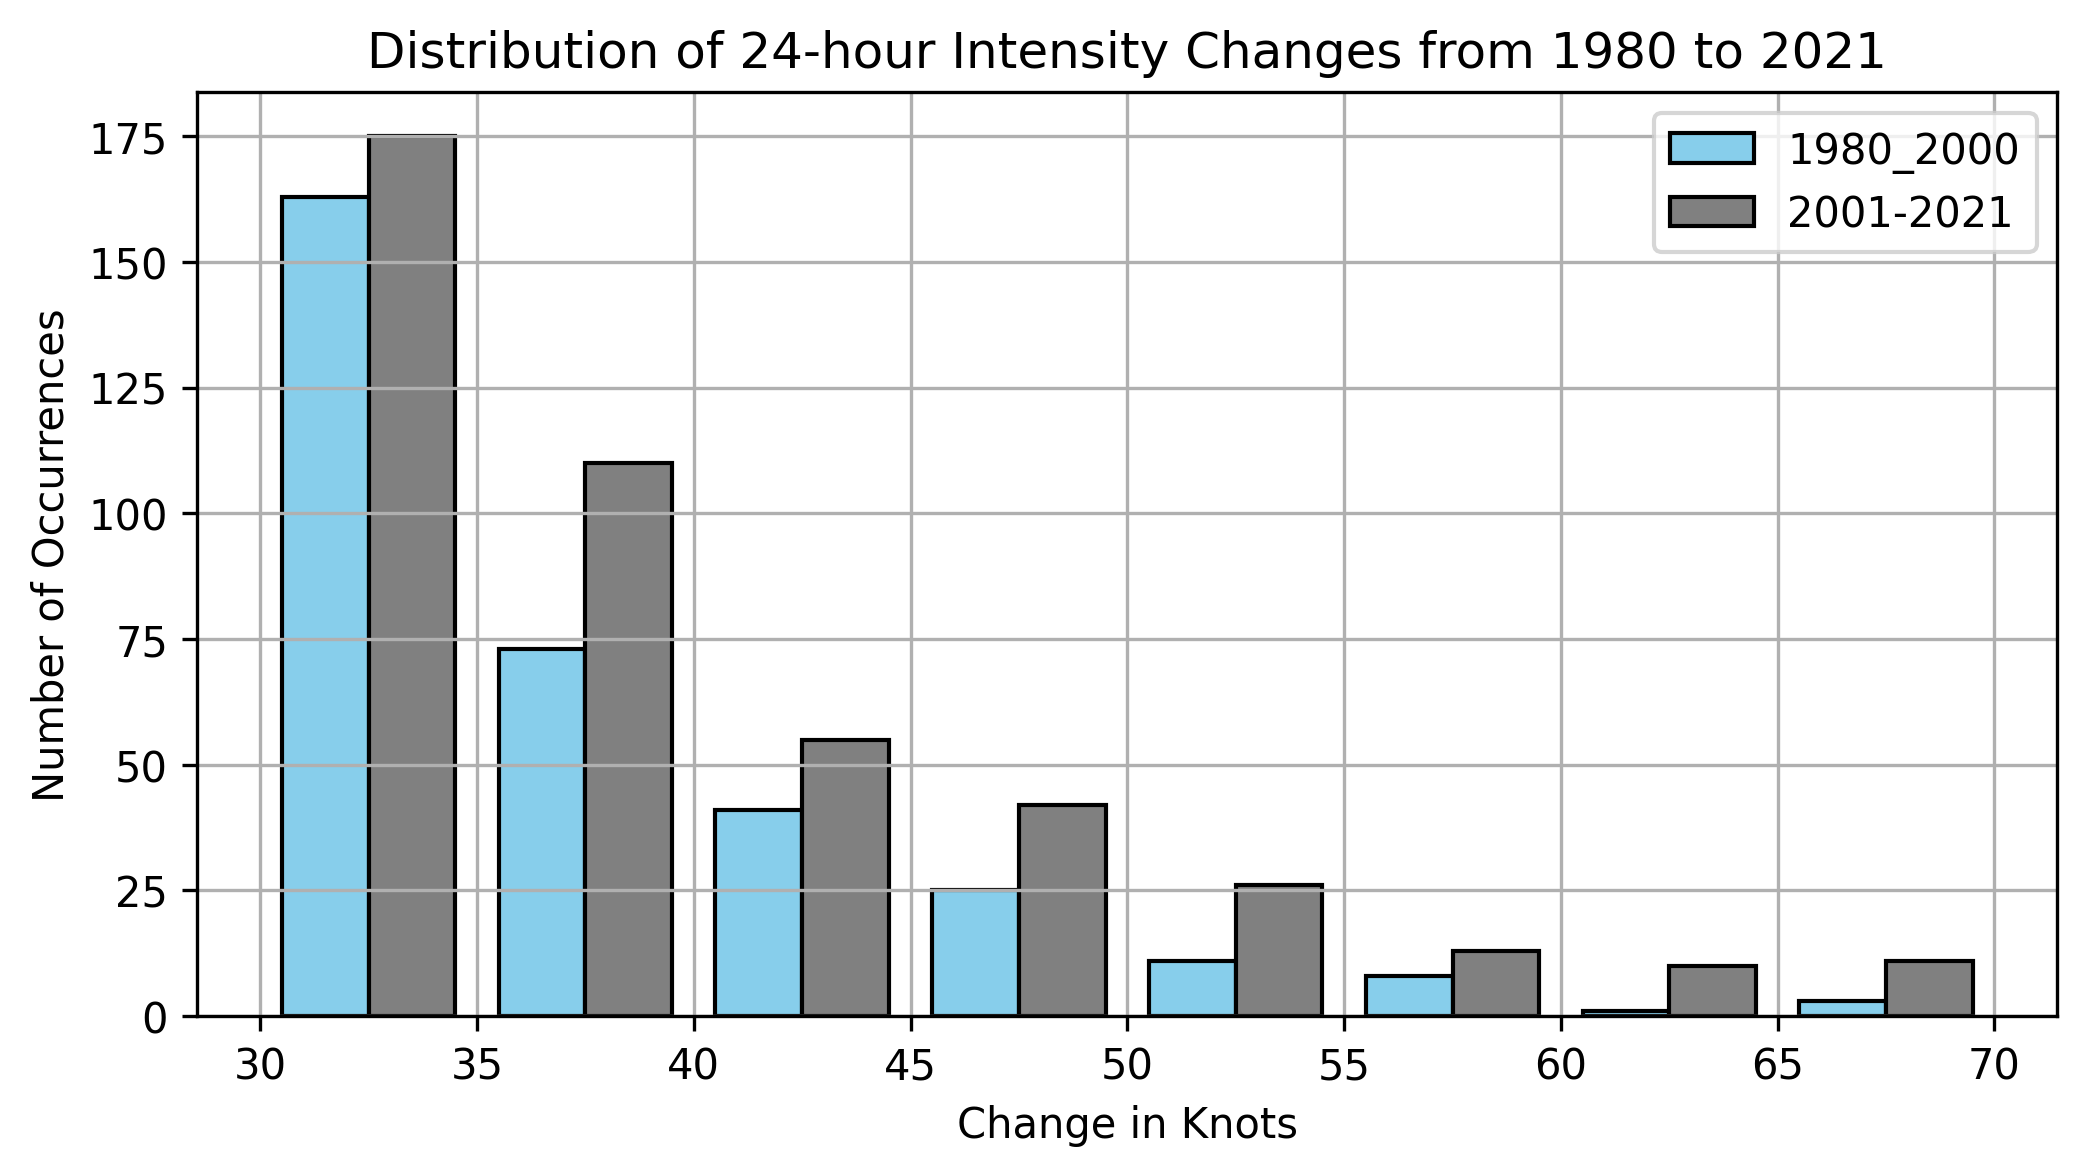

In [10]:
# Convert the lists to numpy arrays for easier manipulation
intensity_changes_1980_2000 = np.array(intensity_changes_1980_2000)
intensity_changes_2001_2021 = np.array(intensity_changes_2001_2021)

# Filter changes that are between 30 and 70 knots
filtered_changes_1980_2000 = intensity_changes_1980_2000[(intensity_changes_1980_2000 >= 30) & (intensity_changes_1980_2000 <= 70)]
filtered_changes_2001_2021 = intensity_changes_2001_2021[(intensity_changes_2001_2021 >= 30) & (intensity_changes_2001_2021 <= 70)]
#%%
# Plotting the overlapping histograms
plt.figure(figsize=(8, 4), dpi = 300)

#plt.hist(filtered_changes_2001_2021, bins=np.arange(30, 75, 5), color='red', alpha=1.0, edgecolor='black', label='2001-2021')
#plt.hist(filtered_changes_1980_2000, bins=np.arange(30, 75, 5), color='darkred', alpha=1.0, edgecolor='black', label='1980-2000')
plt.hist([filtered_changes_1980_2000, filtered_changes_2001_2021], bins=np.arange(30, 75, 5), 
         color=['skyblue', 'grey'], alpha=1.0, edgecolor='black', 
          label=['1980_2000', '2001-2021'])

# Add title and labels
plt.title('Distribution of 24-hour Intensity Changes from 1980 to 2021')
plt.xlabel('Change in Knots')
plt.ylabel('Number of Occurrences')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()